In [136]:

#@RadionTech 
# Calculo de rendimiento UVGI 
#----------------------------------------------------------------------------
''' 
Este programa simula el funcionamiento de un sistema de esterilización basado 
en UVC_GI, considerando el método de cálculo de radiación térmica View Factor 
del libro Radiative Heat Transfer by Michael F. Modest
 
'''

import numpy as np
from time import time 
from tqdm import tqdm_notebook 
import warnings
warnings.filterwarnings('ignore')
    
import numexpr as ne
ne.set_num_threads(8) 

#Mi procesador es octacore ;) 
#el compilador de python no permite el multi thread
#por lo cual este truco de acelerar con la libreria 
#numexpr lo ocupare para los calculos en funciones
#transcendentales u otras operaciones más complejas



#parametros de la lampara

#global radio
radio=1.21             #en cm
#global long_lamp
long_lamp=100        #en cm

intensidad_sup=110        #en microW/cm2


#Inicialmente se necesita crear un espacio vectorial 
#con las coordenadas de un ambiente.

ladox=100
ladoy=150
ladoz=100
#Posiciones por extremales de cada lampara 
#Posicion inicial
lampx1=np.array([50])
lampy1=np.array([0])
lampz1=np.array([50])

#posicion final
lampx2=np.array([50])
lampy2=np.array([100])
lampz2=np.array([50])


x2=lampx2-lampx1
y2=lampy2-lampy1
z2=lampz2-lampz1

p2=x2*x2+y2*y2+z2*z2


ix = np.arange(0, ladox+1, 1).astype(np.float16)   # se construye una base vectorial
iy = np.arange(0, ladoy+1, 1).astype(np.float16)   # ix, iy, iz  
iz = np.arange(0, ladoz+1, 1).astype(np.float16)   # y se escala los puntos de analisis de los ejes

xx,yy,zz = np.meshgrid(ix, iy, iz, indexing='ij')
#la funcion meshgrid construye vectores que contiene
#las combinaciones de los puntos separadamente

#Para poder ejecutar el calculo geometrico por cada punto
# i,j,k reordenamos la combinación de meshgrid en 
#un solo vector 

x=xx.ravel()
y=yy.ravel()
z=zz.ravel()

coord=np.dstack((x,y,z))  #se crea el espacio vectorial de las coordenadas
#es como si ordenara la progresión barriendo plano a plano
#y linea por linea en el orden: y,x,z 
R=np.add(coord,-np.dstack((lampx1,lampy1,lampz1)))
p1=np.sum(R*R,axis=2)
aux= np.sum(R*np.dstack((x2,y2,z2)),axis=2, dtype = float) 
aux1= np.sqrt((p1*p2), dtype = float)
aux=aux[0,:]
aux1=aux1[0,:]
aux_1=ne.evaluate("where(aux1==0,0.0001,aux1)")  
tt= np.true_divide(aux, aux_1)

dotprod=ne.evaluate("arccos(tt)")
dist=ne.evaluate('abs(sin(dotprod))*sqrt(p1)')
distancia=dist[0,:]
posit1=ne.evaluate("where(p1*p2>0, abs(cos(dotprod))*sqrt(p1), radio+0.0001)") 

R1=np.add(coord,-np.dstack((lampx2,lampy2,lampz2)))
p3=np.sum(R1*R1,axis=2)
aux1= np.sum(R1*np.dstack((x2,y2,z2)),axis=2, dtype = float)
aux2= np.sqrt(p3*p2, dtype = float)
aux1=aux1[0,:]
aux2=aux2[0,:]
aux_2=ne.evaluate("where(aux2==0,0.0001,aux2)")  
tt1 = np.true_divide(aux1, aux_2)
dotprod1=ne.evaluate("arccos(tt1)")
posit2=ne.evaluate("where(p3*p2>0,abs(cos(dotprod1))*sqrt(p3),radio+0.0001)")    

dist_axis = np.maximum(posit1,posit2)


   
#Las funciones de computo del View Factor 
#encuentran un cuello de botella en el calculo
#del factor cilindro. 

#Una forma que encuentro para resolver este contratiempo
#y asignarle el modo turbo, sera crear 4 arrays que contengan 
#toda la información de influencia de cada extremo para cada caso: Tanto si cumple 
#o no las condiciones que luego serán depuradas

h=ne.evaluate('where(distancia>radio, distancia/radio,(radio+0.000001)/radio)')
H=ne.evaluate("where(h==1,h+0.000001,h)")

l=np.true_divide(dist_axis,radio)
L=ne.evaluate("where(l==0,l+0.000001,l)")

X=ne.evaluate("(1+H)*(1+H)+(L*L)")
Y=ne.evaluate("(1-H)*(1-H)+(L*L)")
a=ne.evaluate("arctan(L/(sqrt(H*H-1)))/L")

_b=ne.evaluate("X-(2*H)")
_b1=ne.evaluate("arctan(sqrt((X/Y)*(H-1)/(H+1)))/sqrt(X*Y)")
b=ne.evaluate("_b*_b1")
c=ne.evaluate("arctan(sqrt((H-1)/(H+1)))")

VF1=ne.evaluate('(L*(a+b-c))/(pi*H)',local_dict={'pi': np.pi})
   
lo_l=np.true_divide(long_lamp-dist_axis,radio)

lo_L=ne.evaluate("where(lo_l==0,lo_l+0.000001,lo_l)")

lo_X=ne.evaluate("(1+H)*(1+H)+(lo_L*lo_L)")
lo_Y=ne.evaluate("(1-H)*(1-H)+(lo_L*lo_L)")
lo_a=ne.evaluate("arctan(lo_L/(sqrt(H*H-1)))/lo_L")

lo__b=ne.evaluate("lo_X-2*H")
lo__b1=ne.evaluate("arctan(sqrt((lo_X/lo_Y)*(H-1)/(H+1)))/sqrt(lo_X*lo_Y)")
lo_b=ne.evaluate("lo__b*lo__b1")
lo_c=ne.evaluate("arctan(sqrt((H-1)/(H+1)))")
VF2=ne.evaluate('(lo_L*(lo_a+lo_b-lo_c))/(pi*H)',local_dict={'pi': np.pi})
    
vva=ne.evaluate('(VF1+VF2)*intensidad_sup')
    
bey_l=np.true_divide(dist_axis,radio)
bey_L=ne.evaluate("where(bey_l==0,bey_l+0.000001,bey_l)")

bey_X=ne.evaluate("(1+H)*(1+H)+(bey_L*bey_L)")
bey_Y=ne.evaluate("(1-H)*(1-H)+(bey_L*bey_L)")
bey_a=ne.evaluate("arctan(bey_L/(sqrt(H*H-1)))/bey_L")

bey__b=ne.evaluate("bey_X-(2*H)")
bey__b1=ne.evaluate("arctan(sqrt((bey_X/bey_Y)*(H-1)/(H+1)))/sqrt(bey_X*bey_Y)")
bey_b=ne.evaluate("bey__b*bey__b1")
bey_c=ne.evaluate("arctan(sqrt((H-1)/(H+1)))")

VF3=ne.evaluate('(bey_L*(bey_a+bey_b-bey_c))/(pi*H)',local_dict={'pi': np.pi})
    
bey_dbl=np.true_divide(dist_axis-long_lamp,radio)
bey_dbL=ne.evaluate("where(bey_dbl==0,bey_dbl+0.000001,bey_dbl)")

bey_dbX=ne.evaluate("(1+H)*(1+H)+(bey_dbL*bey_dbL)")
bey_dbY=ne.evaluate("(1-H)*(1-H)+(bey_dbL*bey_dbL)")
bey_dba=ne.evaluate("arctan(bey_dbL/(sqrt(H*H-1)))/bey_dbL")

bey__dbb=ne.evaluate("bey_dbX-(2*H)")
bey__dbb1=ne.evaluate("arctan(sqrt((bey_dbX/bey_dbY)*(H-1)/(H+1)))/sqrt(bey_dbX*bey_dbY)")
bey_dbb=ne.evaluate("bey__dbb*bey__dbb1")
bey_dbc=ne.evaluate("arctan(sqrt((H-1)/(H+1)))")

VF4=ne.evaluate('(bey_dbL*(bey_dba+bey_dbb-bey_dbc))/(pi*H)',local_dict={'pi': np.pi})
    
vvb=ne.evaluate('(VF3-VF4)*intensidad_sup')
    
DirectField1=ne.evaluate("where(dist_axis>long_lamp,vva ,vvb)")

DirectField=100*np.divide(np.abs(DirectField1[0,:]),max(DirectField1[0,:]))   #Encontrar valores relativos



Plano Frontal, Corte en X: 


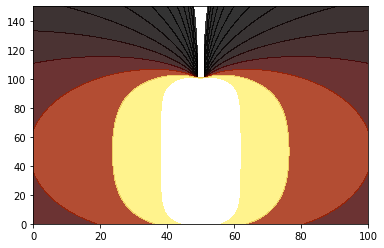

In [137]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y
print('Plano Frontal, Corte en X: ')
planox=50  #int(input()) # Corte en el medio

ax=np.where(coord[0,:,0]==planox,True,False)
tt=DirectField[ax]

levels = np.logspace(-4,1,15,endpoint=True).ravel()


X=np.arange(0,ladoz+1,1)
Y=np.arange(0,ladoy+1,1)
Z=tt.reshape((ladoy+1,ladoz+1))

a=plt.figure()
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.afmhot)

Plano superior, Corte en Y: 


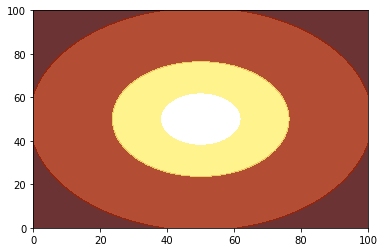

In [154]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista Superior
#En la vista Superior Y es un valor constante
#Z ocupa el valor de x y Y es X
print('Plano superior, Corte en Y: ')
planoy=50  #int(input()) # Corte en el medio

ay=np.where(coord[0,:,1]==planoy,True,False)
tt=DirectField[ay]

levels = np.logspace(-4,1,15,endpoint=True).ravel()


X=np.arange(0,ladoz+1,1)
Y=np.arange(0,ladox+1,1)
Z=tt.reshape((ladox+1,ladoz+1))

a=plt.figure()
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.afmhot)

Plano Frontal, Corte en Z: 


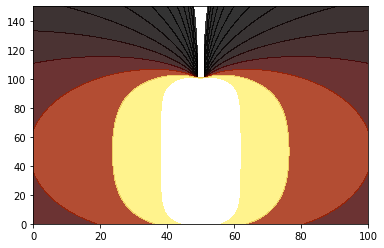

In [208]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

  
#Vista lateral
#En la vista lateral Z es un valor constante
#X ocupa el valor de x y Y es y
print('Plano Frontal, Corte en Z: ')
planoz=50  #int(input()) # Corte en el medio


az=np.where(coord[0,:,2]==planoz,True,False)
tt=DirectField[az]
ord=[]
cd=coord[0,:,:]
for  k in range(150+1):
    for n,(i,j,q) in enumerate(cd[az]):
        if(j==k):
            ord.append(n)
orden=tt[ord]


levels = np.logspace(-4,1,15,endpoint=True).ravel()


X=np.arange(0,ladox+1,1)
Y=np.arange(0,ladoy+1,1)
Z=orden.reshape((ladoy+1,ladox+1))

a=plt.figure()
h = plt.contourf(X,Y,Z,levels,alpha=0.8, cmap=plt.cm.afmhot)

In [188]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
coord.shape
cd=coord[0,:,:]
print(cd[az])

[[  0.   0.  50.]
 [  0.   1.  50.]
 [  0.   2.  50.]
 [  0.   3.  50.]
 [  0.   4.  50.]
 [  0.   5.  50.]
 [  0.   6.  50.]
 [  0.   7.  50.]
 [  0.   8.  50.]
 [  0.   9.  50.]
 [  0.  10.  50.]
 [  0.  11.  50.]
 [  0.  12.  50.]
 [  0.  13.  50.]
 [  0.  14.  50.]
 [  0.  15.  50.]
 [  0.  16.  50.]
 [  0.  17.  50.]
 [  0.  18.  50.]
 [  0.  19.  50.]
 [  0.  20.  50.]
 [  0.  21.  50.]
 [  0.  22.  50.]
 [  0.  23.  50.]
 [  0.  24.  50.]
 [  0.  25.  50.]
 [  0.  26.  50.]
 [  0.  27.  50.]
 [  0.  28.  50.]
 [  0.  29.  50.]
 [  0.  30.  50.]
 [  0.  31.  50.]
 [  0.  32.  50.]
 [  0.  33.  50.]
 [  0.  34.  50.]
 [  0.  35.  50.]
 [  0.  36.  50.]
 [  0.  37.  50.]
 [  0.  38.  50.]
 [  0.  39.  50.]
 [  0.  40.  50.]
 [  0.  41.  50.]
 [  0.  42.  50.]
 [  0.  43.  50.]
 [  0.  44.  50.]
 [  0.  45.  50.]
 [  0.  46.  50.]
 [  0.  47.  50.]
 [  0.  48.  50.]
 [  0.  49.  50.]
 [  0.  50.  50.]
 [  0.  51.  50.]
 [  0.  52.  50.]
 [  0.  53.  50.]
 [  0.  54.  50.]
 [  0.  55

In [189]:
cd1=cd[az]

In [200]:
ord=[]
for  k in range(150+1):
    for n,(i,j,_) in enumerate(cd1):
        if(j==k):
            ord.append(n)
orden=cd1[ord]

In [201]:
print(orden)

[[  0.   0.  50.]
 [  1.   0.  50.]
 [  2.   0.  50.]
 [  3.   0.  50.]
 [  4.   0.  50.]
 [  5.   0.  50.]
 [  6.   0.  50.]
 [  7.   0.  50.]
 [  8.   0.  50.]
 [  9.   0.  50.]
 [ 10.   0.  50.]
 [ 11.   0.  50.]
 [ 12.   0.  50.]
 [ 13.   0.  50.]
 [ 14.   0.  50.]
 [ 15.   0.  50.]
 [ 16.   0.  50.]
 [ 17.   0.  50.]
 [ 18.   0.  50.]
 [ 19.   0.  50.]
 [ 20.   0.  50.]
 [ 21.   0.  50.]
 [ 22.   0.  50.]
 [ 23.   0.  50.]
 [ 24.   0.  50.]
 [ 25.   0.  50.]
 [ 26.   0.  50.]
 [ 27.   0.  50.]
 [ 28.   0.  50.]
 [ 29.   0.  50.]
 [ 30.   0.  50.]
 [ 31.   0.  50.]
 [ 32.   0.  50.]
 [ 33.   0.  50.]
 [ 34.   0.  50.]
 [ 35.   0.  50.]
 [ 36.   0.  50.]
 [ 37.   0.  50.]
 [ 38.   0.  50.]
 [ 39.   0.  50.]
 [ 40.   0.  50.]
 [ 41.   0.  50.]
 [ 42.   0.  50.]
 [ 43.   0.  50.]
 [ 44.   0.  50.]
 [ 45.   0.  50.]
 [ 46.   0.  50.]
 [ 47.   0.  50.]
 [ 48.   0.  50.]
 [ 49.   0.  50.]
 [ 50.   0.  50.]
 [ 51.   0.  50.]
 [ 52.   0.  50.]
 [ 53.   0.  50.]
 [ 54.   0.  50.]
 [ 55.   0